# 6. Phase plane

## Preamble

In [1]:
import numpy as np
from scipy.integrate import odeint
from scipy.integrate import quad
from scipy.interpolate import InterpolatedUnivariateSpline as interpolate
from scipy.optimize import root
from scipy.misc import derivative
import scipy.linalg as lg

import sympy as sp
import fractions as fra

# install the tabulate module using: "conda install tabulate"
from tabulate import tabulate

from ipywidgets import interact

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import matplotlib as mpl
import matplotlib.pyplot as plt

import matplotlib.ticker as ticker
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
%run -i "rcParameters.py"
from mpl_toolkits.mplot3d import Axes3D

plt.rcParams["font.family"]='Times New Roman'
plt.rcParams["mathtext.fontset"]='stix';

In [3]:
# set fontsize in markdown cells
from IPython.core.display import display, HTML, Latex
display(HTML("<style>.rendered_html { font-size: 16px; }</style>"))

## Utility functions

In [4]:
# Phase portrait: streamplot X,Y,Vx=dx/dt,Vy=dy/dt
def PP_2d(x1,x2,y1,y2,f1,f2,ax,nx=100,ny=100,dens=[1,1],lw=1,col='k'):
    ax = ax or plt.gca()
    x = np.linspace(x1,x2,nx)
    y = np.linspace(y1,y2,ny)
    X,Y = np.meshgrid(x,y)
    U = f1(X,Y); V = f2(X,Y)
    ax.streamplot(X,Y,U,V,density=dens,
                 linewidth=lw,color=col,arrowstyle='->')
    return ax

# Phase portrait: streamlines through selected points
def PP_2d_sp(x1,x2,y1,y2,f1,f2,seed_points,ax,nx=100,ny=100,dens=[1,1],lw=1,col='k',ar_s='->'):
    ax = ax or plt.gca()
    x = np.linspace(x1,x2,nx)
    y = np.linspace(y1,y2,ny)
    X,Y = np.meshgrid(x,y)
    U = f1(X,Y); V = f2(X,Y)    
    ax.streamplot(X,Y,U,V,density=dens,start_points=seed_points.T,
                 linewidth=lw,color=col,arrowstyle=ar_s)
    return ax    

In [22]:
# Phase portrait: nullclines
def PP_nc(x1,x2,y1,y2,f1,f2,ax,nx=100,ny=100,lw=1,c1='m',c2='b'):
    ax = ax or plt.gca()
    x = np.linspace(x1,x2,nx)
    y = np.linspace(y1,y2,ny)
    X,Y = np.meshgrid(x,y)
    U = f1(X,Y); V = f2(X,Y)    
    ax.contour(X,Y,U,[0],colors='m')
    ax.contour(X,Y,V,[0],colors='b')
    return ax   

In [5]:
def get_FP_data(f1,f2,tab=True):
    '''
    input: f1(x,y) and f2(x,y) for 2D dynamical system
    output: FPs and attributes: tau, delta, tau^2-4.delta, 
                                eigen-values/-vectors of Jacobian matrix
    '''
    FPs = sp.solve((f1(x,y),f2(x,y)),x,y) 
    FPsd= [{x:a[0],y:a[1]} for a in FPs]
    print('Fixed points: ',FPsd)

    A = lambda x,y: sp.Matrix([f1(x,y),f2(x,y)]).jacobian([x,y])
    display(Latex(r'$A ={}$'.format(sp.latex(A(x,y)))))

    A_FPs = [A(x,y).subs(a) for a in FPsd]
    display(Latex(r'For each FP evaluate $A$, $\tau=Tr(A)$, $\Delta=det(A)$, $\tau^2-4\Delta$, $\lambda_{{1,2}}$, and $v_{{1,2}}$'))
    [display(a) for a in A_FPs];

    tau   = [a.trace() for a in A_FPs]
    display(Latex(r'$\tau = {}$'.format(sp.latex(tau))))
    delta = [a.det()   for a in A_FPs]
    display(Latex(r'$\Delta = {}$'.format(sp.latex(delta))))
    disc  = [t**2 - 4*d for t,d in zip(tau,delta)]
    display(Latex(r'$\tau^2-4\Delta = {}$'.format(sp.latex(disc))))

    # calculate eigenvalues and eigenfunctions of the Jacobian matrices for each FP
    eig_sys = [a.eigenvects() for a in A_FPs]
    mu = [[a[0][0],a[1][0]] for a in eig_sys]
    display(Latex(r'$\lambda_{{1,2}} = {}$'.format(sp.latex(mu))))
    V  = [[list(a[0][2][0]),list(a[1][2][0])] for a in eig_sys]
    display(Latex(r'$V_{{1,2}} = {}$'.format(sp.latex(V))))

    # tabulate data for FPs
    if tab :
        table=[[FPsd[i],tau[i],delta[i],disc[i],mu[i],V[i]] for i in np.arange(len(FPs))]
        print(tabulate(table,headers=('Fixed point','tau','delta','disc','lambda','eigenvectors'),
                   tablefmt='fancy_grid'))
    return FPs, tau, delta, disc, mu, V

## Example 6.1.1 Phase portrait

$\dot{x}=x+\exp(-y)$ <br> $\dot{y}=-y$

In [ ]:
# calculate fixed points (FPs) and their attributes
x,y = sp.symbols('x,y',real=True)

f1 = lambda x,y: x + sp.exp(-y) 
f2 = lambda x,y: -y
FPs = sp.solve((f1(x,y),f2(x,y)),x,y) 
FPsd= [{x:a[0],y:a[1]} for a in FPs]
print('Fixed points: ',FPsd)

A = lambda x,y: sp.Matrix([f1(x,y),f2(x,y)]).jacobian([x,y])
display(Latex(r'$A ={}$'.format(sp.latex(A(x,y)))))

A_FPs = [A(x,y).subs(a) for a in FPsd]
display(Latex(r'For each FPs evaluate $A$, $\tau=Tr(A)$, $\Delta=det(A)$, $\tau^2-4\Delta$, $\lambda_{{1,2}}$, and $v_{{1,2}}$'))
[display(a) for a in A_FPs];

tau   = [a.trace() for a in A_FPs]
display(Latex(r'$\tau = {}$'.format(sp.latex(tau))))
delta = [a.det()   for a in A_FPs]
display(Latex(r'$\Delta = {}$'.format(sp.latex(delta))))
disc  = [t**2 - 4*d for t,d in zip(tau,delta)]
display(Latex(r'$\tau^2-4\Delta = {}$'.format(sp.latex(disc))))

# calculate eigenvalues and eigenfunctions of the Jacobian matrices for each FP
eig_sys = [a.eigenvects() for a in A_FPs]
mu = [[a[0][0],a[1][0]] for a in eig_sys]
display(Latex(r'$\lambda_{{1,2}} = {}$'.format(sp.latex(mu))))
V  = [[list(a[0][2][0]),list(a[1][2][0])] for a in eig_sys]
display(Latex(r'$V_{{1,2}} = {}$'.format(sp.latex(V))))

# tabulate data for FPs
table=[[FPsd[i],tau[i],delta[i],disc[i],mu[i],V[i]] for i in np.arange(len(FPs))]
print(tabulate(table,headers=('Fixed point','tau','delta','disc','lambda','eigenvectors'),
               tablefmt='fancy_grid'))

In [ ]:
# calculate fixed points (FPs) and their attributes using the function get_FP_data(f1,f2) 
x,y = sp.symbols('x,y',real=True)

f1 = lambda x,y: x + sp.exp(-y) 
f2 = lambda x,y: -y

FPs, tau, delta, disc, mu, V = get_FP_data(f1,f2)

In [ ]:
# phase portrait
f1_ = sp.lambdify([x,y],f1(x,y))
f2_ = sp.lambdify([x,y],f2(x,y))
x1 = -5; x2 = 5
y1 = -5; y2 = 5

d0 = 2

nx=ny=50; n1=26
ppx = np.linspace(x1,x2,nx)
ppy = np.linspace(y1,y2,ny)
pp1 = np.ones(len(ppx))
    
fig_611, ax = plt.subplots(figsize=(5,5))
# PP_2d(x1,x2,y1,y2,f1,f2,ax,dens=0.8)

PP_2d_sp(x1,x2,y1,y2,f1_,f2_,np.array([ppx[::2],pp1[::2]*y2]),ax,col='k',dens=d0)
PP_2d_sp(x1,x2,y1,y2,f1_,f2_,np.array([pp1[:n1]*x1,ppy[:n1]]),ax,col='k',dens=d0)

# FPs and streamlines along eigenvector directions
s = 5
for j in np.arange(len(FPs)):
    FP_ = np.array(FPs[j],dtype=float) 
    if tau[j]<0 and delta[j]>0:
        ax.plot(FP_[0],FP_[1],'ro',ms=8,mfc='r',mec='r',lw=2)
    else:
        ax.plot(FP_[0],FP_[1],'ro',ms=8,mfc='w',mec='r',lw=2)
    V_  = np.array(V[j],dtype=float)
    PP_2d_sp(x1,x2,y1,y2,f1_,f2_,(FP_+V_/s).T,ax,col='r',dens=d0,ar_s='-')
    PP_2d_sp(x1,x2,y1,y2,f1_,f2_,(FP_-V_/s).T,ax,col='r',dens=d0,ar_s='-')


ax.set_aspect('equal')
ax.set_xlim(x1,x2)
ax.set_ylim(y1,y2)
ax.set_xticks(np.arange(-4,5,2))
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')

ax.grid()
plt.show()

## Example 6.3.1  

$\dot{x}=-x+x^3$ <br> $\dot{y}=-2y$

In [10]:
# calculate fixed points (FPs) and their attributes using the function get_FP_data(f1,f2) 
x,y = sp.symbols('x,y',real=True)

f1 = lambda x,y: -x + x**3
f2 = lambda x,y: -2*y

FPs, tau, delta, disc, mu, V = get_FP_data(f1,f2)

Fixed points:  [{x: -1, y: 0}, {x: 0, y: 0}, {x: 1, y: 0}]


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Matrix([
[2,  0],
[0, -2]])

Matrix([
[-1,  0],
[ 0, -2]])

Matrix([
[2,  0],
[0, -2]])

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

╒═══════════════╤═══════╤═════════╤════════╤══════════╤══════════════════╕
│ Fixed point   │   tau │   delta │   disc │ lambda   │ eigenvectors     │
╞═══════════════╪═══════╪═════════╪════════╪══════════╪══════════════════╡
│ {x: -1, y: 0} │     0 │      -4 │     16 │ [-2, 2]  │ [[0, 1], [1, 0]] │
├───────────────┼───────┼─────────┼────────┼──────────┼──────────────────┤
│ {x: 0, y: 0}  │    -3 │       2 │      1 │ [-2, -1] │ [[0, 1], [1, 0]] │
├───────────────┼───────┼─────────┼────────┼──────────┼──────────────────┤
│ {x: 1, y: 0}  │     0 │      -4 │     16 │ [-2, 2]  │ [[0, 1], [1, 0]] │
╘═══════════════╧═══════╧═════════╧════════╧══════════╧══════════════════╛


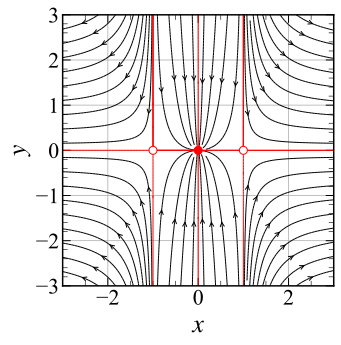

In [11]:
# phase portrait
f1_ = sp.lambdify([x,y],f1(x,y))
f2_ = sp.lambdify([x,y],f2(x,y))
x1 = -3; x2 = 3
y1 = -3; y2 = 3

d0 = 3

n1=40; n2=20; n3=8
ppx = lambda x1,x2,nx: np.linspace(x1,x2,nx)
pp1 = lambda nx: np.ones(nx)
    
fig_631, ax = plt.subplots(figsize=(5,5))
# PP_2d(x1,x2,y1,y2,f1,f2,ax,dens=0.8)

PP_2d_sp(x1,x2,y1,y2,f1,f2,np.array([pp1(n2)*x1,ppx(y1,y2,n2)]),ax,col='k',dens=d0)
PP_2d_sp(x1,x2,y1,y2,f1,f2,np.array([pp1(n2)*2.9,ppx(y1,y2,n2)]),ax,col='k',dens=d0)
PP_2d_sp(x1,x2,y1,y2,f1,f2,np.array([ppx(-0.9,0.9,n3),pp1(n3)*2.9]),ax,col='k',dens=d0)
PP_2d_sp(x1,x2,y1,y2,f1,f2,np.array([ppx(-0.9,0.9,n3),pp1(n3)*y1]),ax,col='k',dens=d0)

# FPs and streamlines along eigenvector directions
s = 4
for j in np.arange(len(FPs)):
    FP_ = np.array(FPs[j],dtype=float) 
    if tau[j]<0 and delta[j]>0:
        ax.plot(FP_[0],FP_[1],'ro',ms=8,mfc='r',mec='r',lw=2)
    else:
        ax.plot(FP_[0],FP_[1],'ro',ms=8,mfc='w',mec='r',lw=2)
    V_  = np.array(V[j],dtype=float)
    PP_2d_sp(x1,x2,y1,y2,f1_,f2_,(FP_+V_/s).T,ax,col='r',dens=d0,ar_s='-')
    PP_2d_sp(x1,x2,y1,y2,f1_,f2_,(FP_-V_/s).T,ax,col='r',dens=d0,ar_s='-')


ax.set_aspect('equal')
ax.set_xlim(x1,x2)
ax.set_ylim(y1,y2)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')

ax.grid()
plt.show()

## Example 6.3.2  

$\dot{x}= -y + a x (x^2+y^2)$ <br> $\dot{y} = x + a y(x^2+y^2)$

In [ ]:
# calculate fixed points (FPs) and their attributes
x,y,a = sp.symbols('x,y,a',real=True)

f1 = lambda x,y: -y + a*x*(x**2+y**2)
f2 = lambda x,y: x + a*y*(x**2+y**2)

FPs, tau, delta, disc, mu, V = get_FP_data(f1,f2)

In [ ]:
# phase portrait

# set a in interval [-2,2]
a = 1

x1 = -3; x2 = 3
y1 = -3; y2 = 3

d0 = 1.4

n1=20; n2=12; n3=10
ppx = lambda x1,x2,nx: np.linspace(x1,x2,nx)
pp1 = lambda nx: np.ones(nx)
    
fig_632, ax = plt.subplots(figsize=(5,5))
# PP_2d(x1,x2,y1,y2,f1,f2,ax,dens=d0)

d0 = 5
# PP_2d_sp(x1,x2,y1,y2,f1,f2,np.array([ppx(0,x2,n2),pp1(n2)*0]),ax,col='k',dens=d0)
PP_2d_sp(x1,x2,y1,y2,f1,f2,np.array([ppx(x1,x2,n2),pp1(n2)*y1]),ax,col='k',dens=d0)
PP_2d_sp(x1,x2,y1,y2,f1,f2,np.array([ppx(x1,x2,n2),pp1(n2)*y2-0.1]),ax,col='k',dens=d0)
PP_2d_sp(x1,x2,y1,y2,f1,f2,np.array([pp1(n2)*x1,ppx(x1,x2,n2)]),ax,col='k',dens=d0)
PP_2d_sp(x1,x2,y1,y2,f1,f2,np.array([pp1(n2)*x2-0.1,ppx(x1,x2,n2)]),ax,col='k',dens=d0)

s = 4
# for each FP 
for j in np.arange(len(FPs)):
    FP_ = np.array(FPs[j],dtype=float) 
# mark FP
    if tau[j]<0 and delta[j]>0:
        ax.plot(FP_[0],FP_[1],'ro',ms=8,mfc='r',mec='r',lw=2)
    else:
        ax.plot(FP_[0],FP_[1],'ro',ms=8,mfc='w',mec='r',lw=2)
# draw streamlines defined along eigenvector directions
#     V_  = np.array(V[j],dtype=real)
#     PP_2d_sp(x1,x2,y1,y2,f1_,f2_,(FP_+V_/s).T,ax,col='r',dens=d0,ar_s='-')
#     PP_2d_sp(x1,x2,y1,y2,f1_,f2_,(FP_-V_/s).T,ax,col='r',dens=d0,ar_s='-')


ax.set_aspect('equal')
ax.set_xlim(x1,x2)
ax.set_ylim(y1,y2)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')

ax.grid()
plt.show()

In [23]:
# calculate fixed points (FPs) and their attributes
x,y = sp.symbols('x,y',real=True)

f1 = lambda x,y: x*(4-y-x**2)
f2 = lambda x,y: y*(x-1)

FPs, tau, delta, disc, mu, V = get_FP_data(f1,f2)

Fixed points:  [{x: -2, y: 0}, {x: 0, y: 0}, {x: 1, y: 3}, {x: 2, y: 0}]


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Matrix([
[-8,  2],
[ 0, -3]])

Matrix([
[4,  0],
[0, -1]])

Matrix([
[-2, -1],
[ 3,  0]])

Matrix([
[-8, -2],
[ 0,  1]])

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

╒═══════════════╤═══════╤═════════╤════════╤══════════════════════════════════╤════════════════════════════════════════════════════╕
│ Fixed point   │   tau │   delta │   disc │ lambda                           │ eigenvectors                                       │
╞═══════════════╪═══════╪═════════╪════════╪══════════════════════════════════╪════════════════════════════════════════════════════╡
│ {x: -2, y: 0} │   -11 │      24 │     25 │ [-8, -3]                         │ [[1, 0], [2/5, 1]]                                 │
├───────────────┼───────┼─────────┼────────┼──────────────────────────────────┼────────────────────────────────────────────────────┤
│ {x: 0, y: 0}  │     3 │      -4 │     25 │ [-1, 4]                          │ [[0, 1], [1, 0]]                                   │
├───────────────┼───────┼─────────┼────────┼──────────────────────────────────┼────────────────────────────────────────────────────┤
│ {x: 1, y: 3}  │    -2 │       3 │     -8 │ [-1 - sqrt(2)*I, -1 + sq

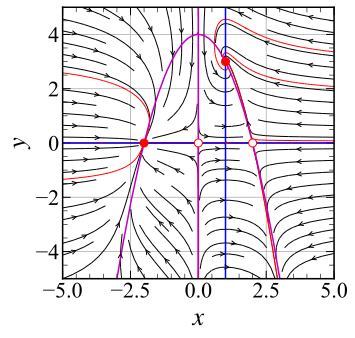

In [24]:
# phase portrait
f1_ = sp.lambdify([x,y],f1(x,y))
f2_ = sp.lambdify([x,y],f2(x,y))
x1 = -5; x2 = 5
y1 = -5; y2 = 5

d0 = 3

n1=40; n2=20; n3=8
ppx = lambda x1,x2,nx: np.linspace(x1,x2,nx)
pp1 = lambda nx: np.ones(nx)
    
fig_631, ax = plt.subplots(figsize=(5,5))
PP_2d(x1,x2,y1,y2,f1,f2,ax,dens=0.8)

#PP_2d_sp(x1,x2,y1,y2,f1,f2,np.array([pp1(n2)*x1,ppx(y1,y2,n2)]),ax,col='k',dens=d0)
#PP_2d_sp(x1,x2,y1,y2,f1,f2,np.array([pp1(n2)*2.9,ppx(y1,y2,n2)]),ax,col='k',dens=d0)
#PP_2d_sp(x1,x2,y1,y2,f1,f2,np.array([ppx(-0.9,0.9,n3),pp1(n3)*2.9]),ax,col='k',dens=d0)
#PP_2d_sp(x1,x2,y1,y2,f1,f2,np.array([ppx(-0.9,0.9,n3),pp1(n3)*y1]),ax,col='k',dens=d0)

# FPs and streamlines along eigenvector directions
s = 4
for j in np.arange(len(FPs)):
    FP_ = np.array(FPs[j],dtype=float) 
    if tau[j]<0 and delta[j]>0:
        ax.plot(FP_[0],FP_[1],'ro',ms=8,mfc='r',mec='r',lw=2)
    else:
        ax.plot(FP_[0],FP_[1],'ro',ms=8,mfc='w',mec='r',lw=2)
    V_  = np.array(V[j],dtype=complex)
    PP_2d_sp(x1,x2,y1,y2,f1_,f2_,(FP_+V_/s).T,ax,col='r',dens=d0,ar_s='-')
    PP_2d_sp(x1,x2,y1,y2,f1_,f2_,(FP_-V_/s).T,ax,col='r',dens=d0,ar_s='-')

PP_nc(x1,x2,y1,y2,f1_,f2_,ax)

ax.set_aspect('equal')
ax.set_xlim(x1,x2)
ax.set_ylim(y1,y2)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')

ax.grid()
plt.show()

## 6.4 Rabbits versus Sheep

Classic ___Lotka-Volterra___ model of competition between two species

$x=$ population of rabbits, $y=$ population of sheep

2D dynamical system: <br>
$\dot{x}=f_1(x,y)=x(3-x-2y)$ <br> $\dot{y}=f_2(x,y)=y(2-x-y)$

In [ ]:
# calculate fixed points (FPs) and their attributes
x,y = sp.symbols('x,y',real=True)

f1 = lambda x,y: x*(3-x-2*y)
f2 = lambda x,y: y*(2-x-y)

FPs, tau, delta, disc, mu, V = get_FP_data(f1,f2)

In [ ]:
# phase portrait
x1 = -0.5; x2 = 5
y1 = -0.5; y2 = 5

d0 = 3

n1=40; n2=10; n3=5
ppx = lambda x1,x2,nx: np.linspace(x1,x2,nx)
pp1 = lambda nx: np.ones(nx)
    
fig_64, ax = plt.subplots(figsize=(6,6))
# PP_2d(x1,x2,y1,y2,f1,f2,ax,dens=0.8)

PP_2d_sp(x1,x2,y1,y2,f1,f2,np.array([pp1(n2)*x2,ppx(0,y2*0.9,n2)]),ax,col='k',dens=d0)
PP_2d_sp(x1,x2,y1,y2,f1,f2,np.array([ppx(0,x2,n2),pp1(n2)*4.9]),ax,col='k',dens=d0)
PP_2d_sp(x1,x2,y1,y2,f1,f2,np.array([ppx(0,1,n3),pp1(n3)*1]),ax,col='k',dens=d0)
PP_2d_sp(x1,x2,y1,y2,f1,f2,np.array([pp1(n3),ppx(0,1,n3)]),ax,col='k',dens=d0)

# FPs and streamlines along eigenvector directions
s = 1e8
for j in np.arange(len(FPs)):
    FP_ = np.array(FPs[j],dtype=float) 
    if tau[j]<0 and delta[j]>0:
        ax.plot(FP_[0],FP_[1],'ro',ms=8,mfc='r',mec='r',lw=2)
    else:
        ax.plot(FP_[0],FP_[1],'ro',ms=8,mfc='w',mec='r',lw=2)
    V_  = np.array(V[j],dtype=float)
    d0 = 3
    PP_2d_sp(x1,x2,y1,y2,f1,f2,(FP_+V_/s).T,ax,col='r',dens=d0,ar_s='-')
    PP_2d_sp(x1,x2,y1,y2,f1,f2,(FP_-V_/s).T,ax,col='r',dens=d0,ar_s='-')


ax.set_aspect('equal')
ax.set_xlim(-0.1,x2)
ax.set_ylim(-0.1,y2)
ax.set_xlabel('rabits')
ax.set_ylabel('sheep')

ax.grid()
plt.show()

## Example 6.5.2  

Particle of mass m moving in a double well potential $V(x) = -x^2/2 + x^4/4$

In [ ]:
# calculate fixed points (FPs) and their attributes
x,y = sp.symbols('x,y',real=True)

f1 = lambda x,y: y
f2 = lambda x,y: x-x**3

FPs, tau, delta, disc, mu, V = get_FP_data(f1,f2)

In [ ]:
# phase portrait
x1 = -2; x2 = 2
y1 = -2; y2 = 2

d0 = 3

n1=30; n2=15; n3=8
ppx = lambda x1,x2,nx: np.linspace(x1,x2,nx)
pp1 = lambda nx: np.ones(nx)
    
fig_652, ax = plt.subplots(figsize=(6,6))
# PP_2d(x1,x2,y1,y2,f1,f2,ax,dens=0.8)

# PP_2d_sp(x1,x2,y1,y2,f1,f2,np.array([pp1(n2)*x1,ppx(y1,y2,n2)]),ax,col='k',dens=d0)
# PP_2d_sp(x1,x2,y1,y2,f1,f2,np.array([pp1(n2)*2.9,ppx(y1,y2,n2)]),ax,col='k',dens=d0)
PP_2d_sp(x1,x2,y1,y2,f1,f2,np.array([ppx(x1,x2,n1),pp1(n1)*0]),ax,col='k',dens=d0)
# PP_2d_sp(x1,x2,y1,y2,f1,f2,np.array([ppx(-0.9,0.9,n3),pp1(n3)*y1]),ax,col='k',dens=d0)

# FPs and streamlines along eigenvector directions
s = 1e6
for j in np.arange(len(FPs)):
    FP_ = np.array(FPs[j],dtype=float) 
    if tau[j]<=0 and delta[j]>0:
        ax.plot(FP_[0],FP_[1],'ro',ms=8,mfc='r',mec='r',lw=2)
    else:
        ax.plot(FP_[0],FP_[1],'ro',ms=8,mfc='w',mec='r',lw=2)

FP_ = FPs[1]; V_  = np.array(V[1],dtype=float)
PP_2d_sp(x1,x2,y1,y2,f1,f2,(FP_+V_/s).T,ax,col='b',dens=d0,ar_s='-',lw=2)


ax.set_aspect('equal')
ax.set_xlim(x1,x2)
ax.set_ylim(y1,y2)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')

ax.grid()
plt.show()

## Example 6.6.1 

$\dot{x}=y-y^3$ <br> $\dot{y}=-x-y^2$

In [ ]:
# calculate fixed points (FPs) and their attributes
x,y = sp.symbols('x,y',real=True)

f1 = lambda x,y: y-y**3
f2 = lambda x,y: -x-y**2

FPs, tau, delta, disc, mu, V = get_FP_data(f1,f2)

In [ ]:
# phase portrait
x1 = -4; x2 = 4
y1 = -4; y2 = 4

d0 = 3

n1=40; n2=28; n3=12
ppx = lambda x1,x2,nx: np.linspace(x1,x2,nx)
pp1 = lambda nx: np.ones(nx)
    
fig_661, ax = plt.subplots(figsize=(6,6))
# PP_2d(x1,x2,y1,y2,f1,f2,ax,dens=0.8)

PP_2d_sp(x1,x2,y1,y2,f1,f2,np.array([ppx(-3.9,0.3,n3),pp1(n3)*0]),ax,col='k',dens=d0)
PP_2d_sp(x1,x2,y1,y2,f1,f2,np.array([ppx(0.4,x2,n3),pp1(n3)*0]),ax,col='k',dens=d0)
PP_2d_sp(x1,x2,y1,y2,f1,f2,np.array([ppx(x1,x2,n3),pp1(n3)*3.9]),ax,col='k',dens=d0)
PP_2d_sp(x1,x2,y1,y2,f1,f2,np.array([ppx(x1,x2,n3),pp1(n3)*-3.9]),ax,col='k',dens=d0)

# FPs and streamlines along eigenvector directions
s = 1e2
for j in np.arange(len(FPs)):
    FP_ = np.array(FPs[j],dtype=float) 
    if tau[j]<=0 and delta[j]>0:
        ax.plot(FP_[0],FP_[1],'ro',ms=8,mfc='r',mec='r',lw=2)
    else:
        ax.plot(FP_[0],FP_[1],'ro',ms=8,mfc='w',mec='r',lw=2)
    if tau[j] != 0:
        V_  = np.array(V[j],dtype=float)
        PP_2d_sp(x1,x2,y1,y2,f1,f2,(FP_+V_/s).T,ax,col='b',dens=d0,ar_s='-',lw=2)
        PP_2d_sp(x1,x2,y1,y2,f1,f2,(FP_-V_/s).T,ax,col='b',dens=d0,ar_s='-',lw=2)


ax.set_aspect('equal')
ax.set_xlim(x1,x2)
ax.set_ylim(y1,y2)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')

ax.grid()
plt.show()

## Example 6.6.3

$\dot{x}=-2\cos(x)-\cos(y)$ <br> $\dot{y}=-2\cos(y)-\cos(x)$

In [ ]:
# calculate fixed points (FPs) and their attributes
x,y = sp.symbols('x,y',real=True)

f1 = lambda x,y: -2*sp.cos(x)-sp.cos(y)
f2 = lambda x,y: -2*sp.cos(y)-sp.cos(x)

FPs, tau, delta, disc, mu, V = get_FP_data(f1,f2)

In [ ]:
# phase portrait
x1 = 0; x2 = 2*np.pi
y1 = 0; y2 = 2*np.pi

f1_ = sp.lambdify([x,y],f1(x,y))
f2_ = sp.lambdify([x,y],f2(x,y))

d0 = 3

n1=40; n2=28; n3=12
ppx = lambda x1,x2,nx: np.linspace(x1,x2,nx)
pp1 = lambda nx: np.ones(nx)
    
fig_663, ax = plt.subplots(figsize=(6,6))
PP_2d(x1,x2,y1,y2,f1_,f2_,ax,dens=1)

# PP_2d_sp(x1,x2,y1,y2,f1,f2,np.array([ppx(-3.9,0.3,n3),pp1(n3)*0]),ax,col='k',dens=d0)
# PP_2d_sp(x1,x2,y1,y2,f1,f2,np.array([ppx(0.4,x2,n3),pp1(n3)*0]),ax,col='k',dens=d0)
# PP_2d_sp(x1,x2,y1,y2,f1,f2,np.array([ppx(x1,x2,n3),pp1(n3)*3.9]),ax,col='k',dens=d0)
# PP_2d_sp(x1,x2,y1,y2,f1,f2,np.array([ppx(x1,x2,n3),pp1(n3)*-3.9]),ax,col='k',dens=d0)

# FPs and streamlines along eigenvector directions
s = [10,50,50,1e4]
for j in np.arange(len(FPs)):
    FP_ = np.array(FPs[j],dtype=float) 
    if tau[j]<=0 and delta[j]>0:
        ax.plot(FP_[0],FP_[1],'ro',ms=8,mfc='r',mec='r',lw=2)
    else:
        ax.plot(FP_[0],FP_[1],'ro',ms=8,mfc='w',mec='r',lw=2)

    V_  = np.array(V[j],dtype=float)
    PP_2d_sp(x1,x2,y1,y2,f1_,f2_,(FP_+V_/s[j]).T,ax,col='b',dens=d0,ar_s='-',lw=2)
    PP_2d_sp(x1,x2,y1,y2,f1_,f2_,(FP_-V_/s[j]).T,ax,col='b',dens=d0,ar_s='-',lw=2)

ax.set_aspect('equal')
ax.set_xlim(x1,x2)
ax.set_ylim(y1,y2)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')

ax.grid()
plt.show()

## 6.7 Pendulum

Equation of motion: $\ddot{\theta}+\omega^2\sin\theta=0$, with $\omega=\sqrt{g/L}$

Using $1/\omega$ as time unit (i.e., $\cal{T}=1/\omega$), the pendulum is equivalent with the 2D dynamical system

$\dot{x}=y$, $\dot{y}=-\sin(x)$, where $x\equiv\theta$ and $y\equiv\dot{\theta}$

In [ ]:
# calculate fixed points (FPs) and their attributes
x,y = sp.symbols('x,y',real=True)

f1 = lambda x,y: y
f2 = lambda x,y: -sp.sin(x)

FPs, tau, delta, disc, mu, V = get_FP_data(f1,f2)

In [ ]:
# phase portrait
eps=1.2
x1 = -np.pi*eps; x2 = np.pi*eps
y1 = -np.pi; y2 = np.pi

f1_ = sp.lambdify([x,y],f1(x,y))
f2_ = sp.lambdify([x,y],f2(x,y))

d0 = 3

n1=40; n2=26; n3=6
ppx = lambda x1,x2,nx: np.linspace(x1,x2,nx)
pp1 = lambda nx: np.ones(nx)
    
fig_67, ax = plt.subplots(figsize=(6,6))
# PP_2d(x1,x2,y1,y2,f1_,f2_,ax,dens=1)

PP_2d_sp(x1,x2,y1,y2,f1_,f2_,np.array([pp1(n2)*0,ppx(y1,y2,n2)]),ax,col='k',dens=d0)
PP_2d_sp(x1,x2,y1,y2,f1_,f2_,np.array([pp1(n3)*(x1+0.1),ppx(-1,1,n3)]),ax,col='k',dens=d0)
PP_2d_sp(x1,x2,y1,y2,f1_,f2_,np.array([pp1(n3)*(x2-0.1),ppx(-1,1,n3)]),ax,col='k',dens=d0)
# PP_2d_sp(x1,x2,y1,y2,f1,f2,np.array([ppx(0.4,x2,n3),pp1(n3)*0]),ax,col='k',dens=d0)
# PP_2d_sp(x1,x2,y1,y2,f1,f2,np.array([ppx(x1,x2,n3),pp1(n3)*3.9]),ax,col='k',dens=d0)
# PP_2d_sp(x1,x2,y1,y2,f1,f2,np.array([ppx(x1,x2,n3),pp1(n3)*-3.9]),ax,col='k',dens=d0)

# FPs and streamlines along eigenvector directions
for j in np.arange(len(FPs)):
    FP_ = np.array(FPs[j],dtype=float) 
    if tau[j]<=0 and delta[j]>0:
        ax.plot(FP_[0],FP_[1],'ro',ms=8,mfc='r',mec='r',lw=2)
    else:
        ax.plot(FP_[0],FP_[1],'ro',ms=8,mfc='w',mec='r',lw=2)
        ax.plot(-FP_[0],FP_[1],'ro',ms=8,mfc='w',mec='r',lw=2)

    s=10    
    FP_=np.array(FPs[1],dtype=float); V_  = np.array(V[1],dtype=float)
    PP_2d_sp(x1,x2,y1,y2,f1_,f2_,(FP_+V_/s).T,ax,col='b',dens=d0,ar_s='-',lw=2)
    PP_2d_sp(x1,x2,y1,y2,f1_,f2_,(FP_-V_/s).T,ax,col='b',dens=d0,ar_s='-',lw=2)

ax.set_aspect('equal')
ax.set_xlim(-np.pi-0.1,np.pi+0.1)
ax.set_ylim(y1,y2)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')

ax.grid()
plt.show()

## 6.7 Pendulum with damping

Equation of motion: $\ddot{\theta}+b\dot\theta+\omega^2\sin\theta=0$

Corresponding 2D dynamical equations (in dimensionless units):

$\dot{x}=y$, $\dot{y}=-\sin(x)-ay$, with  $x\equiv\theta$  and  $y\equiv\dot\theta$ ;  $a=b/\omega$

In [ ]:
# calculate fixed points (FPs) and their attributes
x,y = sp.symbols('x,y',real=True)
a = sp.symbols('a',positive=True)

f1 = lambda x,y: y
f2 = lambda x,y: -sp.sin(x)-a*y

FPs, tau, delta, disc, mu, V = get_FP_data(f1,f2,False)

In [ ]:
# calculate fixed points (FPs) and their attributes
x,y = sp.symbols('x,y',real=True)

a = 0.5
f1 = lambda x,y: y
f2 = lambda x,y: -sp.sin(x)-a*y

FPs, tau, delta, disc, mu, V = get_FP_data(f1,f2,False)

In [ ]:
# phase portrait

eps=1.2
x1 = -np.pi*eps; x2 = np.pi*eps
y1 = -np.pi; y2 = np.pi

f1_ = sp.lambdify([x,y],f1(x,y))
f2_ = sp.lambdify([x,y],f2(x,y))

d0 = 5

n1=40; n2=15; n3=8
ppx = lambda x1,x2,nx: np.linspace(x1,x2,nx)
pp1 = lambda nx: np.ones(nx)
    
fig_67b, ax = plt.subplots(figsize=(6,6))
# PP_2d(x1,x2,y1,y2,f1_,f2_,ax,dens=1)

PP_2d_sp(x1,x2,y1,y2,f1_,f2_,np.array([ppx(x1,x2,n2),pp1(n2)*y2]),ax,col='k',dens=d0)
PP_2d_sp(x1,x2,y1,y2,f1_,f2_,np.array([ppx(x1,x2-0.1,n2),pp1(n2)*y1]),ax,col='k',dens=d0)
PP_2d_sp(x1,x2,y1,y2,f1_,f2_,np.array([pp1(n3)*(x1+0.1),ppx(0,y2,n3)]),ax,col='k',dens=d0)
PP_2d_sp(x1,x2,y1,y2,f1_,f2_,np.array([pp1(n3)*(x2-0.1),ppx(y1,0,n3)]),ax,col='k',dens=d0)

# FPs and streamlines along eigenvector directions
for j in np.arange(len(FPs)):
    FP_ = np.array(FPs[j],dtype=float) 
    if tau[j]<=0 and delta[j]>0:
        ax.plot(FP_[0],FP_[1],'ro',ms=8,mfc='r',mec='r',lw=2)
    else:
        ax.plot(FP_[0],FP_[1],'ro',ms=8,mfc='w',mec='r',lw=2)
        ax.plot(-FP_[0],FP_[1],'ro',ms=8,mfc='w',mec='r',lw=2)

    s=10    
    FP_=np.array(FPs[1],dtype=float); V_  = np.array(V[1],dtype=float)
    PP_2d_sp(x1,x2,y1,y2,f1_,f2_,(FP_+V_/s).T,ax,col='b',dens=d0,ar_s='-',lw=2)
    PP_2d_sp(x1,x2,y1,y2,f1_,f2_,(FP_-V_/s).T,ax,col='b',dens=d0,ar_s='-',lw=2)
    PP_2d_sp(x1,x2,y1,y2,f1_,f2_,(-FP_+V_/s).T,ax,col='b',dens=d0,ar_s='-',lw=2)
    PP_2d_sp(x1,x2,y1,y2,f1_,f2_,(-FP_-V_/s).T,ax,col='b',dens=d0,ar_s='-',lw=2)

ax.set_aspect('equal')
ax.set_xlim(-np.pi-0.1,np.pi+0.1)
ax.set_ylim(y1,y2)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')

ax.grid()
plt.show()